<a href="https://githubtocolab.com/Astolfo2332/white_paper_LoRa/blob/main/LoRa_Ananysis.ipynb" target="_parent\">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" > </a>


<div style="display: flex; align-items: center;">
    <div>
        <h2>Actividad WhitePapers</h2>
        <h2>Miguel López</h2>
        <h2>ID 1001014378</h2>
    </div>
    <img src="https://yt3.ggpht.com/-10IUL9wra6k/AAAAAAAAAAI/AAAAAAAAAAA/UOBLu1uYOOE/s900-c-k-no/photo.jpg" alt="Image description" width="200" style="margin-left: 20px;"/>
</div>

# Una pequeña introducción a los transformers. LoRa, QLoRa y sus efectos en el fine-tuning de Large Language Models.

# 1. Introducción
Gracias al gran éxito de los Transformers, en especial de chatGPT por OpenAI y el gran interés por la industria en adoptar estas nuevas tecnologías, se ha generado la necesidad de modelos más exactos para diferentes casos de uso a nivel profesional. Para ello tradicionalmente se realizaba un reentrenamiento supervisado (con datos etiquetados) completo de los modelos, el cual podía dar a luz problemas como la pérdida de memoria del modelo para otras tareas [1] o principalmente el gran gasto computacional que implica entrenar un modelo, como por ejemplo GPT 3, el cual fue entrenado con 175 billones de parámetros [2]. Además, a diferencia de algunas técnicas de Deep learning, no se puede aplicar simplemente un entrenamiento a las capas superficiales del modelo ya que por la naturaleza de los Transformers, reentrenar su ventana de atención, en otras palabras lo que le permite a estos modelos tener una coherencia de ideas con un texto dado, podria generar pérdida en las capacidades generales del modelo [3]. Para dar solución a todo esto en 2021 se presentó LoRa o Low-Rank Adaptation of Large Language Models [2], donde a través de una adición de una pequeña matriz en capas especificas del modelo se podría reentrenar este a un costo computacional menor, sin perder la mayoría de sus cualidades generales como Large Lenaguage Models (LLM) y sucapacidad de respuestas más precisas dado casos establecidos.


En lo relacionado a términos de optimización de memoria se puede combinar con técnicas como cuantización para bajar el grado de precisión de los pesos flotantes de los modelos de 32 bits a 16, 8 o 4 bits al mismo tiempo que se realiza un fine-tuning con LoRa, conocido como QLoRA [4], perdiendo un poco de precisión en el momento de sus respuestas, pero dejando las puertas abiertas a aplicaciones en por ejemplo teléfonos celulares o sistemas embebidos(por su reducción en el uso de memoría ) para su uso como productos funcionales.  



# 2 Funcionamiento de Transformers y sus implicaciones.

Los transfomers parten de la idea del como mantener la atención de un modelo a lo largo de sus neuronas sin perder ese foco de atención entre ellas. Usando la arquitectura de la forma:


<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/Astolfo2332/white_paper_LoRa/main/images/transformers.png" alt="Fig 1. Arquitectura de Transformers [3]">
    <p><em>Fig 1. Arquitectura de Transformers [3]</em></p>
</div>

Donde inicialmente nos interesa la etapa de encoding, donde las palabras son traducidas a un espacio vectorial dependiendo de su similitud semántica. Como se puede observar a continuación:

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/Astolfo2332/white_paper_LoRa/main/images/3d_wordvec_3.png" alt="Fig 2. Demostración de un embedings en un espacio 3D [5]" width="50%">
    <p><em>Fig 2. Demostración de un embedings en un espacio 3D [5]</em></p>
</div>

De esta manera pudiendo operar matricialmente las palabras (en forma de vectores) con la arquitectura mostrada en la Fig 1.

Anteriormente usando redes neuronales recurrentes (RNN) las cuales después de cada capa iban perdiendo la atención al texto ingresado debido a su naturaleza secuencial, donde en el entrenamiento se puede dar el fenómeno del desvanecimiento de gradientes, el cual implica que los gradientes a medida que pasan por la backpropagation se vuelven 0 o un valor cercano a este impidiendo al modelo aprender nueva información [3] además que la complejidad para volver a esa información requiere un tamaño menor $O(1)$ de Transformers comparado con el $O(n)$ de RNN [3]. Esto se soluciona mediante capas de atención las cuales son dadas por una serie de matrices a las cuales se les aplica una función softmax de la forma:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$


Recordando que la función softmax  es [6]:

$$
\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_{j} \exp(x_j)}
$$

In [ ]:
#Generación de embedings
from transformers import AutoTokenizer


model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)


text = ["El gato es azul", "El perro es verde", "El cielo es azul", "El pasto es verde"]


def encode_text(text, tokenizer):
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )
    return tokenized_inputs["input_ids"][0]

inputs = [encode_text(t, tokenizer).numpy() for t in text]

In [ ]:
import numpy as np

# Encuentra la longitud máxima de las secuencias en 'inputs'
max_length = max(len(seq) for seq in inputs)

# Agrega padding de ceros a cada secuencia para que todas tengan la misma longitud
padded_inputs = [np.pad(seq, (0, max_length - len(seq)), 'constant') for seq in inputs]

padded_inputs

[array([  101,  3449, 11721,  3406,  9686, 17207,  5313,   102]),
 array([  101,  3449,  2566,  3217,  9686, 16184,   102,     0]),
 array([  101,  3449, 25022, 18349,  9686, 17207,  5313,   102]),
 array([  101,  3449,  2627,  2080,  9686, 16184,   102,     0])]

In [ ]:
# Iniciando con numpy aunque este proceso se hace por medio de tensores
L, d_v, d_k = len(padded_inputs[0]), 4, 4



# Generamos valores aleatorios para Q, K, y V
np.random.seed(23)  # Semilla para reproducibilidad

Q = np.matmul(padded_inputs, np.random.rand(L, d_k) * 1e-5)
V = np.matmul(padded_inputs, np.random.rand(L, d_v) * 1e-5)
K = np.matmul(padded_inputs, np.random.rand(L, d_k) * 1e-5)



# Calculamos la atención
# QK^T
QK_T = np.matmul(Q, K.T)

# Dividimos por la raíz cuadrada de d_k
QK_T_scaled = QK_T / np.sqrt(d_k)

# Aplicamos la función softmax
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

attention_weights = softmax(QK_T_scaled)

# Calculamos la salida de la atención
output = np.matmul(attention_weights, V)


print("Capa de atención\n", attention_weights)

print("\nSalida de la atención\n", output)


Capa de atención
 [[0.2517603  0.24117014 0.26620964 0.24085991]
 [0.25137197 0.24425888 0.26028139 0.24408776]
 [0.25219952 0.23427593 0.27991041 0.23361414]
 [0.25133767 0.24455666 0.25970371 0.24440196]]

Salida de la atención
 [[0.30272187 0.37315351 0.24318054 0.17621523]
 [0.30153986 0.3715292  0.24174308 0.17500056]
 [0.30541302 0.37684938 0.24646852 0.17899182]
 [0.30142499 0.37137136 0.24160326 0.17488242]]


En este ejemplo se usan 4 dimensiones, aunque en realidad la entrada de las matrices de atención son mayores. Por ejemplo, si quisiera reentrenar un modelo como GPT 3 el cual cuenta con 16.385 dimensiones [7] y 175 billones de parámetros [2], se incrementaria el gasto computacional para cada iteración. Por ende el uso de menos parámetros especializados para ajustar un modelo es necesario y una de estas soluciones es LoRa

## 3.LoRa [2]
Este permite un ajuste eficiente, mediante la descomposición de bajo rango de las matrices de atención, obteniendo un mejor ajuste con pocos parámetros. Esto quiere decir que si se parte de el cómo funciona una LLM de forma general donde se tiene un  $W_0$ que corresponde las dimensiones de los pesos iniciales de un modelo entrenado , su ajuste esta dado por un $\Delta W$ para que este dé una salida de predicción $h$ de la forma:
$$
h = W_0 x + \Delta W x
$$

Supongase así que existe una descomposición para $\Delta W$ donde $B \in \mathbb{R}^{d \times r}$ y $A \in \mathbb{R}^{r \times k}$, donde r es el rank y d las dimensiones de la matriz del modelo. Así si $\nabla(W) x = BA x$ se tiene que:
$$
h = W_0 x + BA x
$$

De una manera gráfica se puede expresar mediante la comparación de:

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/Astolfo2332/white_paper_LoRa/main/images/reaparam.png" alt="Fig 3. Reparametrización en la que se basa LoRa [2]" width="50%">
    <p><em>Fig 3. Reparametrización en la que se basa LoRa [2]</em></p>
</div>


Así los pesos de $A$ y $B$ son cambiados en el fine-tuning del modelo.

In [ ]:
#De una manera práctica se tiene:

#Supongamos un valor h

h = np.random.rand(d_k)

#Donde los pesos iniciales son aleatorios
W = np.random.rand(d_k, d_v)

#Establecemos un X de entrada

X = np.random.rand(d_k, 1)

def normal_tuning(W, X, h):
    #Calculamos el producto punto de W y X
    WX = np.dot(W, X)
    #Generamos la matriz delta_W en ceros
    delta_W = np.zeros_like(W)
    #Ajustamos los pesos de delta_W a base de h
    for i in range(W.shape[0]):
        delta_W[i], _, _, _ = np.linalg.lstsq(X.T, h[i] - WX[i], rcond=None)
    return delta_W

delta_W = normal_tuning(W, X, h)

#Solución de h
normal_h = np.dot(W, X) + np.dot(delta_W, X)

print("Valor de h:")
print(h)

print("\nAjuste de pesos normal:")
print(normal_h.T)

print("\nCon una matriz delta_W:")
print(delta_W)

#De la misma manera podemos ajustar los pesos de A y B, en este caso para ser prácticos solo ajustaremos
#Los pesos de B al ser todos 0

#Creamos la clase de LoRa
class LoRa_tuning:
    def __init__(self, A, h, W, X,r):
        #Inicializamos las variables
        self.A = A
        self.h = h
        self.W = W
        self.X = X
        self.B = np.zeros((W.shape[0], r))
        self.d = W.shape[0]
    def __call__(self):
        #Calculamos los productos punto de A y X y W y X
        Ax = np.dot(self.A, self.X)
        Wx = np.dot(self.W, self.X)
        #Ajustamos los pesos de B a base de h
        for i in range(self.B.shape[0]):
            self.B[i], _, _, _ = np.linalg.lstsq(Ax.T, h[i] - Wx[i], rcond=None)
        return self.B
    def solution(self):
        # Calculamos la solución
        return np.dot(self.W, self.X) + np.dot(np.dot(self.B, self.A), self.X)
    def is_equal(self):
        #Confirmamos que los tamaños de W y A*B sean iguales
        return self.W.shape == np.dot(self.B, self.A).shape
    def a_dot_b(self):
        #Calculamos A*B
        return np.dot(self.B, self.A)

r = 2
A = np.random.rand(r, d_k)


LoRa = LoRa_tuning(A, h, W, X,r)
B = LoRa()

#Confirmamos que los tamaños de W y A*B sean iguales
print("\nTamaños de W y A*B iguales:", LoRa.is_equal())

print("\nAjuste de pesos con A y B:")
print(LoRa.solution().T)

print("\nCon A:")
print(LoRa.A)

print("\nCon B:")
print(B)


Valor de h:
[0.63938988 0.41702811 0.6272325  0.39643064]

Ajuste de pesos normal:
[[0.63938988 0.41702811 0.6272325  0.39643064]]

Con una matriz delta_W:
[[-0.06088618 -0.49694735 -0.44204427 -0.4775679 ]
 [-0.03393741 -0.27699402 -0.24639153 -0.26619208]
 [-0.00223585 -0.01824883 -0.01623269 -0.01753718]
 [-0.07928901 -0.64714951 -0.575652   -0.62191263]]

Tamaños de W y A*B iguales: True

Ajuste de pesos con A y B:
[[0.63938988 0.41702811 0.6272325  0.39643064]]

Con A:
[[0.56478545 0.2982329  0.18519292 0.78085279]
 [0.15521475 0.60111895 0.73804002 0.5663141 ]]

Con B:
[[-0.35074381 -0.49795333]
 [-0.19550147 -0.27755474]
 [-0.01287996 -0.01828577]
 [-0.45675601 -0.64845955]]


Al final se obtiene el mismo resultado de ajuste, con menos parámetros que calcular en éste ejemplo, solo cambiando de pesos los 8 valores de la matriz $B$ a diferencia de los 16 del $\Delta W$, reduciendo así la cantidad de parámetros a utilizar,correspondiente 2/3 de la VRAM necesaria para el entrenamiento, además de poder entrenar modelos más grandes como GPT-3 en menos GPU reduciendo la latencia entre estas, así como también el costo de computo y un aumento en la velocidad de entrenamiento en aproximadamente 25 % [2].

Sin embargo, si se requieren hacer pruebas de concepto o encapsular modelos en microcontroladores o situaciones donde no se tenga tanta memoria para inferencia o entrenamiento, se requiere un paso extra tanto para su entrenamiento como su almacenamiento y una de estas soluciones es la cuantización.


## 4. QLoRa


En este método se consta de dos partes, la primera ya conocida referente a cómo se puede aplicar LoRa y el porqué es útil para realizar el fine-tuning de LLMs, y ahora la cuantización. Esta técnica permite reducir los bits en los cuales se guardan los pesos de un modelo como se mencionó anteriormente en el caso de GPT 3 el cual contiene 175 billones de parámetros [2], los cuales están almacenados en pesos de flotante a 32 bits, ó también en la mayoría de LLM actuales de 16 bits.

Sin embargo, un modelo de 65 billones de parámetros pasa de 780 GB a menos de 48 GB con una eficiencia similar al modelo entrenado completamente aplicando cuantización [4]. Esto se logró mediante la suposición de que los pesos de los modelos siguen una distribución normal, de esta forma se pueden segmentar todas las secciones de la curva en sectores más grandes o pequeños que tendrán una nueva representación de los parámetros. Dicho proceso puede ser revertido a la hora de inferencia,  además con el uso de un compaginador de memoria esta puede ser trasladada a la CPU para evitar el sobre flujo en la GPU como se puede observar a continuación.


<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/Astolfo2332/white_paper_LoRa/main/images/quanti.png" alt="Fig 4. Métodos de fine-tuning y QLoRa [4]" width="60%">
    <p><em>Fig 4. Métodos de fine-tuning y QLoRa [4] </em></p>
</div>


Así, la cuantización se puede lograr por medio de bloques, en si la cuantización se logra por dos métodos 4 bit NormalFloat (NF4) y una doble cuantización. El final es “discretizar” la información como se puede observar a continuación


<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/Astolfo2332/white_paper_LoRa/main/images/ex_cuanti.png" alt="Fig 5. Ejemplo gráfico de como funciona la cuantización [8]" width="60%">
    <p><em>Fig 5. Ejemplo gráfico de como funciona la cuantización [8]</em></p>
</div>


Donde los sw son los quantiles a discretizar y, como se observa, la mayoría de datos discretizados se encuentran cercanos a la media de la distribución

**NF4**: en este método se usan quantiles donde se agrupan valores de la distribución, dichos quantiles pueden codificar los datos del grupo de números que estén dentro de su conjunto, la principal dificultad es que no se tienen en cuenta los valores extremos de los pesos que en algunos casos son las partes más importantes en los modelos [4]. Para mitigar esto se pueden normalizar los pesos del modelo o escalarlos para una distribución en la que pueda funcionar el NF4, en rangos de -1 a 1, con una distribución estándar de $\sigma$. Así se pueden obtener dos partes de una distribución normal, una positiva y negativa las cuales son representadas por un $2^{k-1}$ para la parte positiva y $2^{k-1}+1$. Para dicha estimación se usa la siguiente fórmula:

$$
q_i = \frac{1}{2} \left( Q_X\left(\frac{i}{2^k + 1}\right) + Q_X\left(\frac{i+1}{2^k + 1}\right) \right)
$$

**Doble cuantización**: Como su nombre lo índica, es una cuantización doble. Esto trae ventajas en términos de memoria, ya que se reduce la huella dependiendo del bloque de memoria a usar, en el caso del paper se usan 64 para cada peso dando como resultando una constante de cuantización de $32 bits /64 = 0.5 bits$, y obteniendo así un peso de 8 bits, el cual pasa por otro proceso de cuantización, donde se tienen entonces $8 bits / 64 + 32 bits / (64 * 256)$ (del paso anterior) $= 0.127$.

Estos dos métodos combinados con LoRa dependiendo del caso obtiene resultandos muy similares a un entrenamiento normal.


In [ ]:
#Para mostrar como se puede realizar este proceso se toma un modelo base

import numpy as np
from transformers import DistilBertModel, DistilBertTokenizer
import torch

# Cargar el modelo y el tokenizador
model_name = "distilbert-base-uncased"
model = DistilBertModel.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Extraer los pesos originales del modelo
original_weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:  # Solo tomamos los pesos entrenables
        original_weights[name] = param.detach().numpy()

print("Pesos originales extraídos:")




Pesos originales extraídos:


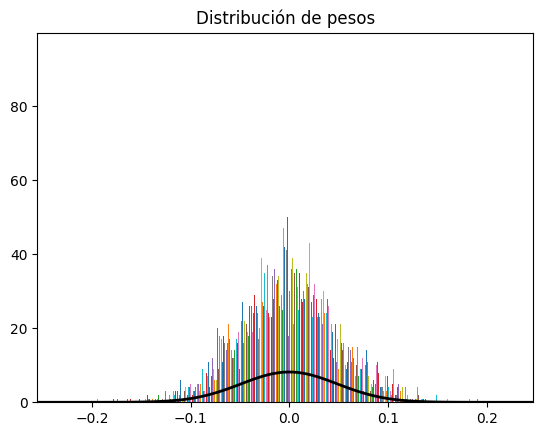

In [ ]:
import matplotlib.pyplot as plt
#Graficamos uno de las capas de pesos para mostrar su distribución y es muy similar a la normal
from scipy.stats import norm

data = original_weights["transformer.layer.4.attention.q_lin.weight"]

mu, std = norm.fit(data)
xmin = data.min()
xmax = data.max()
plt.xlim(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
plt.hist(data, bins=100)
plt.title("Distribución de pesos")
plt.show()

Se puede apreciar que la distribución de los pesos es muy similar a una distribución normal, lo cual es un requisito para la cuantización de los pesos.

In [ ]:
# Definir parámetros de la cuantización
k = 4  # Cuantización en k bits
num_levels = 2 ** k  # Niveles de cuantización
block_size = 64  # Tamaño del bloque 64 como en el paper

quantized_weights = {}
scale_factors = {}

for name, weight in original_weights.items():
    shape = weight.shape
    flat_weight = weight.flatten()
    quantized = []
    scales = []

    # Dividir los pesos en bloques
    for i in range(0, len(flat_weight), block_size):
        block = flat_weight[i:i+block_size]

        # Calcular rango y escala del bloque
        min_val = block.min()
        max_val = block.max()
        scale = (max_val - min_val) / (num_levels - 1) if max_val > min_val else 1.0
        zero_point = -min_val / scale

        # Cuantizar el bloque
        quant_block = ((block - min_val) / scale).clip(0, num_levels - 1).round().astype(np.uint8)

        quantized.append(quant_block)
        scales.append((min_val, scale, zero_point))

    # Reconstruir la matriz cuantizada
    quantized_weights[name] = (np.concatenate(quantized), scales)

# Descuantización
dequantized_weights = {}
for name, (quantized, scales) in quantized_weights.items():
    original_shape = original_weights[name].shape
    dequantized_blocks = []

    # Procesar cada bloque
    block_start = 0
    for min_val, scale, zero_point in scales:
        block_end = block_start + block_size
        quant_block = quantized[block_start:block_end]
        block_start = block_end

        # Descuantizar el bloque
        dequant_block = quant_block * scale + min_val
        dequantized_blocks.append(dequant_block)

    # Reconstruir la matriz descuantizada
    dequantized_weights[name] = np.concatenate(dequantized_blocks).reshape(original_shape)


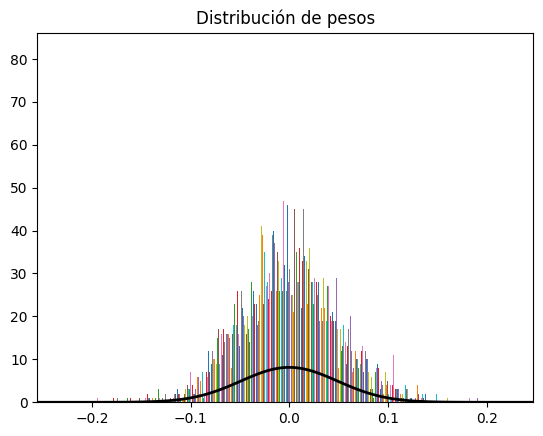

In [ ]:
import matplotlib.pyplot as plt
#Graficamos uno de las capas de pesos para mostrar su distribución y es muy similar a la normal
from scipy.stats import norm

data = dequantized_weights["transformer.layer.4.attention.q_lin.weight"]

mu, std = norm.fit(data)
xmin = data.min()
xmax = data.max()
plt.xlim(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
plt.hist(data, bins=100)
plt.title("Distribución de pesos")
plt.show()


Se obtuvo la misma gráfica de pesos mostrada anteriormente, solo que almacenada en 8 bits en vez de 32 bits. Así se puede realizar el proceso de cuantización y descuantización de los pesos de un modelo de LLM.

## 5. Caso práctico de uso

En mi trabajo final tuve que clasificar pregrados en clases para reducir la cantidad de información, esto se logro con un modelo especifico para esta tara conocidos como zero shoot clasification, que se encargan en a partir de una lista de palabras relacionar las de entrada. En este caso vamos a usar una parte de estos datos con un modelo que no esta diseñado para esta tarea.

El código mostrado es una modificación de ShawhinT [8]

### Para amd

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm6.2
!pip install transformers
!pip install optimum
# Note, if you don't want to reinstall BNBs dependencies, append the `--no-deps` flag!
!pip install 'https://github.com/bitsandbytes-foundation/bitsandbytes/releases/download/continuous-release_multi-backend-refactor/bitsandbytes-0.44.1.dev0-py3-none-manylinux_2_24_x86_64.whl'
!pip install auto-gptq

Looking in indexes: https://download.pytorch.org/whl/rocm6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 GB 15.0 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.2 MB/s eta 0:00:00a 0:00:01
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl (11 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.2.0-py3-none-any.whl (170 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 MB 18.0 MB/s eta 0:00:0000:0100:01
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 21.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.

### Para Nvidia

In [1]:
!pip install optimum
!pip install auto-gptq
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requir

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
import transformers
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Primero cargamos un modelo previamente cuantizado

In [3]:
model_name = "TheBloke/CapybaraHermes-2.5-Mistral-7B-GPTQ"
model = AutoModelForCausalLM.from_pretrained(model_name,
                                            device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.
/home/kaiki/anaconda

Se inicia el tokenizador

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Configuramos LoRa

En este caso lo configuramos como un casual LM, para así mantener su uso general y que sea funcional para nuestra tarea en especifico que sería clasificar texto. recordando el r del ranking de LoRa y su $\alpha$ para la delimitación de matrices y en que capa (target_modules) vamos a aplicar el entrenamiento.

In [5]:
model.train()
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
  r=8,
  lora_alpha=32,
  target_modules=["q_proj"],
  lora_dropout=0.5,
  bias="none",
  task_type="CAUSAL_LM"
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

g++ (GCC) 14.2.1 20240910
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

trainable params: 2,097,152 || all params: 264,523,776 || trainable%: 0.7928


Organizamos el dataset

In [6]:
import json
with open("data/class_labels.json", "r") as f:
    class_labels = json.load(f)

In [7]:
categories = list(set(class_labels.values()))

prompt = f"""<|im_start|>system
Eres un modelo de lenguaje que va a clasificar textos en diferentes categorías.
""" + str(categories) + """ ¿cuál de es la más adecuada para el siguiente texto?:<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant
{response}
"""

In [8]:
import random
from datasets import Dataset, DatasetDict
indices = random.sample(range(len(class_labels)), 150)
data = {"example": [prompt.format(prompt=text, response=category) for text, category in class_labels.items()]}
data_train = {"example": [data["example"][i] for i in indices]}

indices = random.sample(range(len(class_labels)), 150)
data_test = {"example": [data["example"][i] for i in indices]}

dataset = Dataset.from_dict(data_train)
dataset_test = Dataset.from_dict(data_test)


dataset_dict = DatasetDict({"train": dataset, "test": dataset_test})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['example'],
        num_rows: 150
    })
    test: Dataset({
        features: ['example'],
        num_rows: 150
    })
})


In [9]:
def tokenizer_func(example: dict):
    text = example["example"]

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text, #Se pasa el texto
        return_tensors="np",
        truncation=True, #En el caso que no cumpla con 512 se llena de tokens vacios
        max_length=512 #Se ajusta a 512 debido a que es el tamaño del modelo
    )
    return tokenized_inputs

tokenized_data = dataset_dict.map(tokenizer_func, batched=True)


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [10]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [11]:
lr = 2e-4
batch_size = 4
num_epochs = 30

training_args = transformers.TrainingArguments(
    output_dir= "../models/",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    fp16=True,
    optim="paged_adamw_8bit",

)

In [12]:
# Se configura el entrenador
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    args=training_args,
    data_collator=data_collator
)

# Se entrena el modelo
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()
model.config.use_cache = True

/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/auto_gptq/nn_modules/qlinear/qlinear_cuda.py:313: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  out = torch.matmul(x, weights)
/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/transformers/models/mistral/modeling_mistral.py:456: UserWarning: Memory Efficient attention on Navi31 GPU is

Epoch,Training Loss,Validation Loss
1,2.664400,1.373475
2,0.814900,0.421645
3,0.340400,0.311942
4,0.277000,0.281766
5,0.248700,0.271533
6,0.232600,0.264863
7,0.221900,0.267920
8,0.213900,0.263998
9,0.205500,0.264662
10,0.199700,0.268372


/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/kaiki/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwar

Probamos los resultados del entrenamiento

In [38]:

data = {"example": [prompt.format(prompt=text, response="") for text, _ in class_labels.items()]}
resp = {"resp": [category for category in class_labels.values()]}

indices = random.sample(range(len(class_labels)), 50)
data_test =  [data["example"][i] for i in indices]
data_resp = [resp["resp"][i] for i in indices]
inputs = tokenizer(data_test, return_tensors="pt", padding=True, truncation=True, max_length=512)

In [39]:
model.eval()

with torch.inference_mode():
    model_output = model.generate(
        input_ids=inputs["input_ids"].to(device),
        attention_mask=inputs["attention_mask"].to(device),
        max_new_tokens=100,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

generated_text = tokenizer.batch_decode(model_output, skip_special_tokens=True)

model_responses = generated_text

In [86]:
import pandas as pd

def repeats(string):
    #(regex no funcionó)
    for x in range(1, len(string)):
        #Vamos tomando el string desde atrás
        substring = string[:x]
        #Así si multiplicamos dicho valor por 2 y es igual al string significa que se repite
        if substring * 2 == string:
            return substring
    return string

#Se limpia la información de la respuesta del modelo
model_responses_2 = [response.split("assistant")[1].replace("\n","").split(" ")[0] for response in model_responses]
#Eliminamos las palabras que se duplican ejm:educacióneducación
model_responses_2 =  [repeats(response) for response in model_responses_2]
df = pd.DataFrame({"model_response": model_responses_2, "resp": data_resp})
df

,model_response,resp
0,humanidades,humanidades
1,educación,ciencias
2,ingeniería,ingeniería
3,humanidades,humanidades
4,derecho,derecho
5,educación,educación
6,educación,educación
7,salud,salud
8,humanidades,humanidades
9,humanidades,investigación


In [87]:
from sklearn.metrics import accuracy_score
#Se calcula la precisión del modelo

accuracy = accuracy_score(df["resp"], df["model_response"])

print(f"Accuracy: {accuracy * 100} %")

Accuracy: 86.0 %


Así mostrando lo util que puede ser el entrenamiento e inferencia de un modelo grande cuantizado, en este caso el modelo en su etapa de entrenamiento e inferencia solo ocupó 5.2 GB de VRAM.


<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/Astolfo2332/white_paper_LoRa/main/images/vram.png" alt="Fig 6. VRAM usada para el entrenamiento e inferencia del modelo" width="60%">
    <p><em>Fig 6. VRAM usada para el entrenamiento e inferencia del modelo</em></p>
</div>

Además de aun contar con sus capacidades generales de respuesta

In [31]:
prompt_2 = """<|im_start|>system
Eres un asistente de cocina especializado en dulces. responde a la siguiente pregunta:<|im_end|>
<|im_start|>user
Como puedo hacer un pastel de zanahoria?<|im_end|>
<|im_start|>assistant"""

inputs_test = tokenizer(prompt_2, return_tensors="pt").to(device)

with torch.inference_mode():
    model_output = model.generate(
        input_ids=inputs_test["input_ids"],
        attention_mask=inputs_test["attention_mask"],
        max_new_tokens=150,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

In [37]:
generated_text = tokenizer.batch_decode(model_output, skip_special_tokens=True)
print(generated_text[0].split("assistant")[1])


Para hacer un delicioso pastel de zanahoria, sigue estos pasos:

**Ingredientes:**

Para el pastel:

* 250 g de harina de pan
* 1/2 taza de mantequilla
* 1/2 taza de azúcar
* 1 huevo
* 1/2 taza de azúcar moreno
* 1/2 taza de harina de soja
* 1/2 taza de fécula de maní
* 1/2 taza de leche de almendras
* 1 taza


## 6. Conclusiones



En conclusión, se destaca la importancia y versatilidad de la cuantización en las LLMs, una técnica que optimiza el uso de recursos computacionales al reducir la precisión de los parámetros del modelo, permitiendo su implementación en dispositivos con recursos limitados sin sacrificar significativamente el rendimiento. Por otro lado, LoRA ofrece un enfoque eficiente para el fine-tuning, actualizando únicamente matrices de bajo rango en lugar de ajustar todos los parámetros del modelo, lo que reduce significativamente los requerimientos de memoria.

Al combinar estas dos técnicas, se obtuvo QLoRA, un enfoque que permite afinar modelos previamente cuantizados de manera eficiente y precisa. Esto no solo reduce el costo computacional del fine-tuning, sino que también mantiene la calidad de las predicciones en tareas específicas. Esta combinación se demostró claramente en el ejemplo aplicado, donde el modelo ajustado conserva sus capacidades de inferencia mientras se adapta a tareas concretas de manera eficiente. La integración de la cuantización y LoRA subraya su importancia en el desarrollo de soluciones escalables y personalizadas, adaptadas a diversos contextos y restricciones de hardware.

## Bibliografía


[1]	Y. Liu et al., «Understanding LLMs: A Comprehensive Overview from Training to Inference», 2024, arXiv. doi: 10.48550/ARXIV.2401.02038.

[2]	E. J. Hu et al., «LoRA: Low-Rank Adaptation of Large Language Models», 2021, arXiv. doi: 10.48550/ARXIV.2106.09685.

[3]	A. Vaswani et al., «Attention Is All You Need», 2017, arXiv. doi: 10.48550/ARXIV.1706.03762.

[4]	T. Dettmers, A. Pagnoni, A. Holtzman, y L. Zettlemoyer, «QLoRA: Efficient Finetuning of Quantized LLMs», 2023, arXiv. doi: 10.48550/ARXIV.2305.14314.

[5]	E. KIM, «Understanding Multi-Dimensionality in Vector Space Modeling», Pythonic Excursions. Accedido: 17 de noviembre de 2024. [En línea]. Disponible en: https://aegis4048.github.io/understanding_multi-dimensionality_in_vector_space_modeling

[6]	M. Jensen, K. Abbas, K. S. Abduljabbar, y J. Banks, «Automated Classification of Cell Level of HEp-2 Microscopic Images Using Deep Convolutional Neural Networks-Based Diameter Distance Features», JUCS - J. Univers. Comput. Sci., vol. 29, pp. 432-445, may 2023, doi: 10.3897/jucs.96293.

[7]	«OpenAI Platform». Accedido: 17 de noviembre de 2024. [En línea]. Disponible en: https://platform.openai.com

[8] «YouTube-Blog/LLMs/qlora/qlora_example.ipynb at main · ShawhinT/YouTube-Blog», GitHub. . [En línea]. Disponible en: https://github.com/ShawhinT/YouTube-Blog/blob/main/LLMs/qlora/qlora_example.ipynb

